# Introduction

This notebook examines the Stack Overflow survey results from all years, downloaded in Jan 2021 from https://insights.stackoverflow.com/survey, examining the languages worked with by correspondants.

Questions
1) What languages are most popular?
2) Which languages are typically used together?
3) Is there a difference in languages by profession level?
4) How does language affect salary? - Model to predict salary based on combinations of languages?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression

# Import Data and Check

In [2]:
df = pd.read_csv('./survey_results_public_years.csv')
print(df.shape)
df.head()

(64461, 61)


,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


In [3]:
# Identify columns
print(list(df))

['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq', 'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc', 'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith', 'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors', 'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith', 'MiscTechDesireNextYear', 'MiscTechWorkedWith', 'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps', 'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch', 'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms', 'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites', 'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear', 'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount', 'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength', 'Trans', 'UndergradMajor', 'WebframeDesireNextYear', 'WebframeWorkedWith', 'WelcomeChange', 'WorkWeekHrs', 'YearsCode', 'YearsCodePro']


# Question 1: What are the most popular languages?

In [4]:
# Clean data - split multiple answers into languages
languages = df['LanguageWorkedWith'].dropna().str.split(';', expand=True)

# fold into series to calculate value counts
languages_list = []
for i in range(languages.shape[1]):
    languages_list.extend(languages[i].tolist())

langs = pd.Series(languages_list)
lang_counts = langs.value_counts()

print(lang_counts)

JavaScript               38822
HTML/CSS                 36181
SQL                      31413
Python                   25287
Java                     23074
Bash/Shell/PowerShell    18980
C#                       18041
PHP                      15007
TypeScript               14578
C++                      13707
C                        12487
Go                        5038
Kotlin                    4468
Ruby                      4046
Assembly                  3553
VBA                       3499
Swift                     3397
R                         3288
Rust                      2929
Objective-C               2340
Dart                      2280
Scala                     2052
Perl                      1796
Haskell                   1222
Julia                      519
dtype: int64


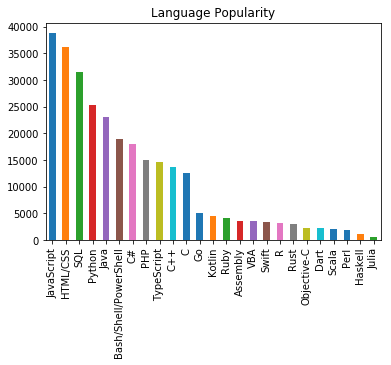

In [5]:
# Visualise language counts

lang_counts.plot(kind='bar', legend=None);
plt.title('Language Popularity');
plt.show()

# Question 2: Which languages are typically learned together?

In [6]:
# Create dataframe with languages vs respondent (1: language learned, 0 otherwise)

cols = list(lang_counts.index)

langs_df = pd.DataFrame(0, index=languages.index, columns=cols)

for i in list(languages.index):
    for col in cols:
        if col in list(languages.loc[i]):
            langs_df.loc[i][col] = 1


In [7]:
# check produces same counts
langs_df.sum()

JavaScript               38822
HTML/CSS                 36181
SQL                      31413
Python                   25287
Java                     23074
Bash/Shell/PowerShell    18980
C#                       18041
PHP                      15007
TypeScript               14578
C++                      13707
C                        12487
Go                        5038
Kotlin                    4468
Ruby                      4046
Assembly                  3553
VBA                       3499
Swift                     3397
R                         3288
Rust                      2929
Objective-C               2340
Dart                      2280
Scala                     2052
Perl                      1796
Haskell                   1222
Julia                      519
dtype: int64

In [8]:
langs_df_corr = langs_df.corr()
print(langs_df_corr)

                       JavaScript  HTML/CSS       SQL    Python      Java  \
JavaScript               1.000000  0.571387  0.241400 -0.051947  0.040661   
HTML/CSS                 0.571387  1.000000  0.276681 -0.023514  0.031384   
SQL                      0.241400  0.276681  1.000000  0.041259  0.117297   
Python                  -0.051947 -0.023514  0.041259  1.000000  0.070167   
Java                     0.040661  0.031384  0.117297  0.070167  1.000000   
Bash/Shell/PowerShell    0.058213  0.070587  0.133655  0.221396  0.055857   
C#                       0.100907  0.117349  0.194801 -0.093667 -0.026260   
PHP                      0.262324  0.295465  0.252649 -0.009164  0.047644   
TypeScript               0.310886  0.235278  0.099487 -0.057063  0.015889   
C++                     -0.065460 -0.011116 -0.004864  0.191754  0.151532   
C                       -0.051983  0.017943  0.009053  0.193617  0.179297   
Go                       0.043350 -0.004316  0.023980  0.125740  0.041950   

In [9]:
# remove self correlation, so can retrieve maxima
np.fill_diagonal(langs_df_corr.values, 0)

In [10]:
print('Most often used with JavaScript is: {}'.format(langs_df_corr['JavaScript'].idxmax()))
print('Most often used with C++ is: {}'.format(langs_df_corr['C++'].idxmax()))
print('Most often used with Swift is: {}'.format(langs_df_corr['Swift'].idxmax()))
print('Most often used with Python is: {}'.format(langs_df_corr['Python'].idxmax()))

Most often used with JavaScript is: HTML/CSS
Most often used with C++ is: C
Most often used with Swift is: Objective-C
Most often used with Python is: Bash/Shell/PowerShell


# Question3: Is there a difference in languages by profession level?

In [11]:
# Examine professional levels
df['MainBranch'].value_counts()

I am a developer by profession                                                   47193
I am a student who is learning to code                                            7970
I am not primarily a developer, but I write code sometimes as part of my work     5502
I code primarily as a hobby                                                       2314
I used to be a developer by profession, but no longer am                          1183
Name: MainBranch, dtype: int64

In [12]:
# Filter language matrix by profession level responses

# concat
langs_prof_df = pd.concat([df['MainBranch'], langs_df], axis=1)

# drop nan rows (where correspondant hasn't given a response for language or profession)
langs_prof_df.dropna(axis = 0, how = 'any', inplace = True)

langs_prof_df.head()

,MainBranch,JavaScript,HTML/CSS,SQL,Python,Java,Bash/Shell/PowerShell,C#,PHP,TypeScript,...,VBA,Swift,R,Rust,Objective-C,Dart,Scala,Perl,Haskell,Julia
0,I am a developer by profession,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,I am a developer by profession,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,I code primarily as a hobby,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,"I used to be a developer by profession, but no...",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,I am a developer by profession,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# split into train-test set, so can measure performance
X = langs_prof_df.iloc[:, 1:]

# Convert class to categorical
le = preprocessing.LabelEncoder()
Y = le.fit_transform(langs_prof_df.iloc[:, 0])

X_train, X_test, y_train, y_test = train_test_split(X, Y)


In [14]:
clf = RandomForestClassifier(max_depth=3, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

print(accuracy_score(y_test, y_pred, normalize=True))

             precision    recall  f1-score   support

          0       0.74      1.00      0.85     10625
          1       0.00      0.00      0.00      1708
          2       0.00      0.00      0.00      1192
          3       0.00      0.00      0.00       528
          4       0.00      0.00      0.00       252

avg / total       0.55      0.74      0.63     14305

0.742747291157


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Beacuse of the heavy class imbalance, the results are most accurate for the professional developer class. The Random Forest classifier has not dealt well with class imbalance.

Compare with SVC.

In [16]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [17]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

print(accuracy_score(y_test, y_pred, normalize=True))

             precision    recall  f1-score   support

          0       0.76      0.99      0.86     10625
          1       0.62      0.09      0.15      1708
          2       0.52      0.09      0.15      1192
          3       0.00      0.00      0.00       528
          4       0.00      0.00      0.00       252

avg / total       0.68      0.75      0.67     14305

0.752394267739


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVC is slightly more accuracte than Random Forest, but still fails completely on the two smallest classes. However, the results do suggest that different languages are used by differing professional levels.

# Question 4: How does language affect salary?

In [18]:
# Filter language matrix by profession level responses

# concat
langs_comp_df = pd.concat([df['ConvertedComp'], langs_df], axis=1)

# drop nan rows (where correspondant hasn't given a response for language or profession)
langs_comp_df.dropna(axis = 0, how = 'any', inplace = True)

langs_comp_df.head()

,ConvertedComp,JavaScript,HTML/CSS,SQL,Python,Java,Bash/Shell/PowerShell,C#,PHP,TypeScript,...,VBA,Swift,R,Rust,Objective-C,Dart,Scala,Perl,Haskell,Julia
7,116000.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,32315.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,40070.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,14268.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,38916.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Convert class to categorical
Xc = langs_comp_df.iloc[:, 1:]
Yc = le.fit_transform(langs_comp_df.iloc[:, 0])

Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, Yc)

In [20]:
reg = LinearRegression().fit(Xc_train, yc_train)
reg.score(Xc_train, yc_train)

0.10538312125855287

In [21]:
yc_pred = reg.predict(Xc_test)
mean_squared_error(yc_test, yc_pred)

3197104.2180965347

It does not look possible to predict salary based on languages used since the error is so high.